# Datathon_길잃은 오리들 프로덕션

우리는 OTT 플랫폼에 컨텐츠를 제작 및 납품하는 독립 프로덕션의 데이터 엔지니어로, 각 플랫폼의 컨텐츠 특징과 컨텐츠 특성 분포 등을 파악하여 우리가 제작한 컨텐츠를 어느 플랫폼에 납품할지, 또는 제작예정인 컨텐츠의 제작지원을 요청할지를 판단하기에 도움이 될 인사이트를 도출하고자 합니다.

우리가 제작할 컨텐츠의 상세는 아직 미정이거나 우리 부서의 담당업무가 아니므로, 해당 부분에 대한 제약은 없습니다. 즉, 어떤 컨텐츠를 제작하기로 결정하더라도 해당 컨텐츠를 어느 플랫폼에 납품할지를 판단하는 데에 유용한 인사이트를 도출하는 것이 목적입니다.

가설 1: 각 컨텐츠가 출시되는 국가들은 통계적으로 군집화가 가능할 것이며, 그 군집은 플랫폼별로 차이가 있을 것이다.
가설 2: 각 컨텐츠의 장르는 출시되는 국가에 따라 다르게 분포할 것이다.

## 데이터 전처리
### 데이터 전처리 기초
#### 필요 라이브러리 임포트



In [1]:
import re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import MDS
from datetime import datetime

os.chdir("/home/technocracy90/Datathon")

#### 데이터 다운로드 및 적재

In [2]:
# Kaggle 데이터 다운로드
import kagglehub
netflix_path = kagglehub.dataset_download("shivamb/netflix-shows")
amazon_path = kagglehub.dataset_download("shivamb/amazon-prime-movies-and-tv-shows")
disney_path = kagglehub.dataset_download("shivamb/disney-movies-and-tv-shows")

# 저장된 경로 확인
print(netflix_path)
print(amazon_path)
print(disney_path)

# cash 디렉토리에서 작업 디렉토리로 복사
from distutils.dir_util import copy_tree
root_path = os.path.join(os.getenv('HOME'), 'Datathon')
copy_tree(netflix_path, root_path)
copy_tree(amazon_path, root_path)
copy_tree(disney_path, root_path)

# 데이터 경로 업데이트
def update_path(data_path):
    name = data_path.split("/")[-3]
    name = name.split("-")[0]

    for file in os.listdir(root_path):
        filename, extension = os.path.splitext(file)
        filename = filename.split("_")[0]
        if extension == ".csv" and name == filename:
            return  os.path.join(root_path, file)

netflix_path = update_path(netflix_path)
amazon_path = update_path(amazon_path)
disney_path = update_path(disney_path)

# 저장된 경로 확인
print(netflix_path)
print(amazon_path)
print(disney_path)

# 데이터 적재
netflix = pd.read_csv(netflix_path)
amazon = pd.read_csv(amazon_path)
disney = pd.read_csv(disney_path)

/home/technocracy90/.cache/kagglehub/datasets/shivamb/netflix-shows/versions/5
/home/technocracy90/.cache/kagglehub/datasets/shivamb/amazon-prime-movies-and-tv-shows/versions/1
/home/technocracy90/.cache/kagglehub/datasets/shivamb/disney-movies-and-tv-shows/versions/2
/home/technocracy90/Datathon/netflix_titles.csv
/home/technocracy90/Datathon/amazon_prime_titles.csv
/home/technocracy90/Datathon/disney_plus_titles.csv


#### 데이터 전처리: 1차

In [3]:
#데이터 형태 확인
print(netflix.info())
print(amazon.info())
print(disney.info())

netflix

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       9668 non-null   object
 1   type     

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


### 분석대상 컬럼 설정 및 간소화

#### "title", "cast", "director" 컬럼을 드랍하는 이유:
첫 문단의 설명에서 명시했듯, 이번 분석의 목적은 우리가 제작할 컨텐츠를 납품할 대상 플랫폼에 대한 인사이트를 도출하는 것입니다. 그런데 cast와 director는 우리 프로덕션의 능력과 자원에 의해 크게 제약되며, 데이터를 통해 도출한 인사이트가 있더라도 이를 반영하기 쉽지 않습니다. 마찬가지로 title 역시 우리 프로덕션의 방향성 및 마케팅 의사결정에 의해 결정되어야 하므로 이번 EDA의 목적에서 벗어납니다.

#### "duration" 컬럼을 드랍하는 이유:
해당 데이터는 movie의 경우 상영시간, tv show의 경우 시즌 및 에피소드를 나타냅니다. 이는 컨텐츠의 type에 따라 전혀 다른 두 형태의 데이터를 나타내는 것으로, 사실상 type 컬럼에 종속됩니다. 한편, duration 칼럼을 type에 따라 movie의 경우 상영시간, tv show의 경우 에피소드로 분리하여 분석하는 것은 경우에 따라 유효할 가능성을 배제할 수 없으나, 특히 tv show의 경우 방영 시즌은 프로덕션의 의사에 따라 쉽게 결정할 수 없으며, movie의 상영시간은 편집의도에 의해 크게 좌우되므로 역시 프로덕션이 쉽게 결정할 수 없습니다.

#### "show_id" 컬럼을 패딩하는 이유:
초기 데이터상 show_id 컬럼은 인덱스와 중복되는 것처럼 보일 수 있으나, 데이터를 조작함에 따라 index는 계속해서 바뀔 수 있으며, 따라서 show_id 컬럼으로 특정 데이터포인트를 지시해야 할 필요성이 있습니다. 그러나 show_id 컬럼의 뒤에 따라오는 숫자가 패딩되어 있지 않아, 일부 정렬 알고리즘에 따라서는 원하는 방식으로 정렬하기 어렵습니다. (예시: s1, s2, s3이 아닌 s1, s11, s111으로 정렬됨) 따라서 정렬을 용이하게 하기 위해 show_id 컬럼을 4자리로 패딩합니다.

In [4]:
# 분석하지 않을 컬럼 드랍
netflix = netflix.drop(columns=["title", "cast", "director", "duration"])
amazon = amazon.drop(columns=["title", "cast", "director", "duration"])
disney = disney.drop(columns=["title", "cast", "director", "duration"])

#show_id 패딩 함수 작성 및 적용:
def pad_show_id(show_id):
    pattern = re.compile(r"s(\d+)")
    result = pattern.sub(lambda match: f"s{int(match.group(1)):04d}", show_id)
    return result

netflix['show_id'] = netflix['show_id'].apply(pad_show_id)
amazon['show_id'] = amazon['show_id'].apply(pad_show_id)
disney['show_id'] = disney['show_id'].apply(pad_show_id)

In [5]:
#데이터 형태 확인
print(netflix.info())
print(amazon.info())
print(disney.info())

netflix

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   country       7976 non-null   object
 3   date_added    8797 non-null   object
 4   release_year  8807 non-null   int64 
 5   rating        8803 non-null   object
 6   listed_in     8807 non-null   object
 7   description   8807 non-null   object
dtypes: int64(1), object(7)
memory usage: 550.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       9668 non-null   object
 1   type          9668 non-null   object
 2   country       672 non-null    object
 3   date_added    155 non-null    object
 4   release_year  9668 non-null   int64 
 5   rating      

,show_id,type,country,date_added,release_year,rating,listed_in,description
0,s0001,Movie,United States,"September 25, 2021",2020,PG-13,Documentaries,"As her father nears the end of his life, filmm..."
1,s0002,TV Show,South Africa,"September 24, 2021",2021,TV-MA,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s0003,TV Show,NaN,"September 24, 2021",2021,TV-MA,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s0004,TV Show,NaN,"September 24, 2021",2021,TV-MA,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s0005,TV Show,India,"September 24, 2021",2021,TV-MA,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...
8802,s8803,Movie,United States,"November 20, 2019",2007,R,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,NaN,"July 1, 2019",2018,TV-Y7,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,United States,"November 1, 2019",2009,R,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,United States,"January 11, 2020",2006,PG,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


#### 년도 및 일자 데이터를 datetime으로 변환
초기 데이터상 date_adde, relaese_year 칼럼은 각각 문자열과 정수 자료형으로 제공되며, 따라서 특정 일자 혹은 년도 이후의 데이터포인트를 추출하거나, 각 시간의 차이를 구하는 작업 등이 어렵습니다. 따라서 추후 분석의 용이성을 위해 해당 컬럼을 datetime으로 변환합니다.

In [6]:
# 년도 및 일자 데이터를 datetime으로 변환
def date_and_time(dataframe):
    dataframe['date_added'] = dataframe['date_added'].astype('str')
    dataframe['release_year'] = dataframe['release_year'].astype('str')
    counter_release = 0 # release_year 변환 작업이 실패한 횟수
    counter_added = 0 # date_added 컬럼이 결측치인 횟수
    
    for entry, index in zip(dataframe['release_year'], dataframe.index): # release_year를 datetime으로 변환
        if type(entry) != datetime:
            try:
                dataframe.at[index, 'release_year'] = datetime.strptime(str(entry), "%Y")
            except Exception as e:
                counter_release += 1
                print(f"{e}:\n{index}, {entry}")

    
    for entry, index in zip(dataframe['date_added'], dataframe.index): # date_added를 datetime으로 변환하고, 결측치일 경우 release_year를 대신 사용
        try:
            dataframe.at[index, 'date_added'] = datetime.strptime(entry.lstrip(), "%B %d, %Y")
        except Exception as e:
            counter_added += 1
            dataframe.at[index, 'date_added'] = dataframe.at[index, 'release_year']
    
    print(f'{counter_release} release_dates have not converted!') # relase_year 변환에 실패한 횟수 출력
    print(f'{counter_added} date_added were missing!') # date_added가 결측치여서 release_year를 대신 사용한 횟수 출력

date_and_time(netflix)
date_and_time(amazon) # 아마존 데이터셋의 경우 date_added의 절대다수가 결측치임을 확인
date_and_time(disney)

0 release_dates have not converted!
10 date_added were missing!
0 release_dates have not converted!
9513 date_added were missing!
0 release_dates have not converted!
3 date_added were missing!


In [7]:
# 데이터 형태 확인을 위해 release_year와 date_added 컬럼 출력
print(netflix[['release_year', 'date_added']])
print(disney[['release_year', 'date_added']])

             release_year           date_added
0     2020-01-01 00:00:00  2021-09-25 00:00:00
1     2021-01-01 00:00:00  2021-09-24 00:00:00
2     2021-01-01 00:00:00  2021-09-24 00:00:00
3     2021-01-01 00:00:00  2021-09-24 00:00:00
4     2021-01-01 00:00:00  2021-09-24 00:00:00
...                   ...                  ...
8802  2007-01-01 00:00:00  2019-11-20 00:00:00
8803  2018-01-01 00:00:00  2019-07-01 00:00:00
8804  2009-01-01 00:00:00  2019-11-01 00:00:00
8805  2006-01-01 00:00:00  2020-01-11 00:00:00
8806  2015-01-01 00:00:00  2019-03-02 00:00:00

[8807 rows x 2 columns]
             release_year           date_added
0     2016-01-01 00:00:00  2021-11-26 00:00:00
1     1988-01-01 00:00:00  2021-11-26 00:00:00
2     2011-01-01 00:00:00  2021-11-26 00:00:00
3     2021-01-01 00:00:00  2021-11-26 00:00:00
4     2021-01-01 00:00:00  2021-11-25 00:00:00
...                   ...                  ...
1445  2009-01-01 00:00:00  2021-06-04 00:00:00
1446  2009-01-01 00:00:00  2021-04-

### added_delay 컬럼 생성 및 통계분석
#### added_delay 컬럼을 생성하는 이유
거듭 상기하듯 이번 데이터 분석의 목적은 신규 컨텐츠를 제작 및 납품할 때에 관련된 인사이트를 도출하는 것이며, 따라서 해당 컨텐츠가 플랫폼에 탑재된 시점과 출시된 시점 사이의 차이가 유의한 영향을 끼칩니다. 위 코드블럭의 출력에서 알 수 잇듯, 일부 컨텐츠는 출시 후 수 년에서 수십 년이 지난 후에 플랫폼에 추가되는데, 우리의 컨텐츠가 제작 후 수십 년 뒤에 플랫폼에 납품되지를 바라지는 않을 것입니다. 이러한 데이터포인트의 특성이 데이터 분석에 포함된다면, 제공되는 인사이트가 크게 왜곡될 수 있습니다. 따라서 출시일과 탑재일의 차이를 확인하고 분석에 반영하기 위해 해당 컬럼을 생성합니다.

added_delay 컬럼을 release_year로 그룹화하여 출력한 결과, release_year와 added_delay 사이에 음의 상관관계가 있는 것이 포착됩니다. OTT 플랫폼이 활성화되기 이전의 컨텐츠들도 탑재되는 점을 고려할 때 당연한 결과이며, 이에 대한 통계적 관찰을 시도합니다.

In [8]:
# date_added와 release_year의 차이를 added_delay 컬럼으로 생성 및 출시연도별 지연일 평균 출력
netflix['added_delay'] = netflix['date_added'] - netflix['release_year']
print(netflix.groupby(['release_year'])['added_delay'].mean())

disney['added_delay'] = disney['date_added'] - disney['release_year']
print(disney.groupby(['release_year'])['added_delay'].mean())

# amazon 데이터셋은 date_added 항목의 결측치가 너무 많아 분석에서 제외
# amazon['added_delay'] = amazon['date_added'] - amazon['release_year']
# print(amazon.groupby(['release_year'])['added_delay'].mean())

release_year
1925-01-01            34331 days 00:00:00
1942-01-01            27483 days 00:00:00
1943-01-01            27118 days 00:00:00
1944-01-01            26753 days 00:00:00
1945-01-01            26739 days 18:00:00
                         ...             
2017-01-01    582 days 23:08:22.325581392
2018-01-01    461 days 23:24:50.845684392
2019-01-01    355 days 09:13:37.864077668
2020-01-01    253 days 00:31:43.882476392
2021-01-01    149 days 00:19:27.567567568
Name: added_delay, Length: 74, dtype: object
release_year
1928-01-01             33553 days 00:00:00
1932-01-01             32092 days 00:00:00
1933-01-01             31726 days 00:00:00
1934-01-01             31361 days 00:00:00
1935-01-01             31031 days 18:00:00
                          ...             
2017-01-01    1205 days 14:57:23.478260864
2018-01-01     898 days 08:29:32.307692304
2019-01-01     502 days 17:27:16.363636360
2020-01-01     310 days 17:41:03.157894736
2021-01-01        213 days 22:39:21.6

In [9]:
# 컨텐츠 출시년도와 컨텐츠 탑재일간의 상관관계를 분석하는 함수 작성 및 적용

def release_added_corr(dataframe):  
    subframe = dataframe[['date_added', 'release_year']].copy()
    subframe['date_added'] = subframe['date_added'].apply(lambda x: x.strftime('%Y%m%d')) 
    subframe['release_year'] = subframe['release_year'].apply(lambda x: x.strftime('%Y')) 

    return subframe.corr(), subframe    

release_added_corr(netflix) # 함수의 작동을 확인하기 위해, netflix 데이터프레임에 대해 시험 적용

(              date_added  release_year
 date_added      1.000000      0.112798
 release_year    0.112798      1.000000,
      date_added release_year
 0      20210925         2020
 1      20210924         2021
 2      20210924         2021
 3      20210924         2021
 4      20210924         2021
 ...         ...          ...
 8802   20191120         2007
 8803   20190701         2018
 8804   20191101         2009
 8805   20200111         2006
 8806   20190302         2015
 
 [8807 rows x 2 columns])

In [10]:
# Y년 이후의 데이터포인트만 추출하는 함수 작성
def slice_release_year(dataframe, year):
    recent_dataframe = dataframe[dataframe["release_year"] > datetime.strptime(year, "%Y")]
    recent_dataframe = recent_dataframe.reset_index(drop=True)
    
    return recent_dataframe

netflix_recent = slice_release_year(netflix, "2018")
release_added_corr(netflix_recent)

(              date_added  release_year
 date_added      1.000000      0.779009
 release_year    0.779009      1.000000,
      date_added release_year
 0      20210925         2020
 1      20210924         2021
 2      20210924         2021
 3      20210924         2021
 4      20210924         2021
 ...         ...          ...
 2570   20190405         2019
 2571   20200327         2019
 2572   20190809         2019
 2573   20191203         2019
 2574   20190813         2019
 
 [2575 rows x 2 columns])

#### added_delay 컬럼에 대한 가설변경 및 추가작업
위 두 코드블럭 중 첫번째 코드블럭에서는 release_year와 date_added의 상관계수를 나이브하게 도출하였고, 0.11의 상관계수가 나와 상관관계가 매우 낮다는 결과를 얻었습니다. 이는 우리의 처음 직관과 모순되는 결과입니다. 이에 임의의 년도인 2018년 이후 데이터만을 이용하여 상관계수를 다시 도출한 결과, 0.78의 상관계수가 나와 상관관계가 매우 높다는 결과를 얻었습니다.

두 결과가 다른 이유는 release_year가 오래된 컨텐츠, 특히 OTT의 본격적인 영업 이전에 출시된 컨텐츠의 경우 플랫폼에 해당 컨텐츠를 탑재하는 시점은 출시년도와 거의 관련이 없기 때문일 것입니다. 수십년 된 고전 컨텐츠를 탑재할 때에는 해당 컨텐츠가 출시된 지 몇 년이 지났는지보다 해당 컨텐츠가 얼마나 고전으로서의 가치를 갖는지 등이 중점이 될 수밖에 없습니다.

이를 통해, 컨텐츠 출시년도를 기점으로 슬라이싱한 데이터포인트를 대상으로 release_year와 date_added 간의 상관관계를 검정하는 것으로 작업가설을 변경합니다.

In [11]:
# 시간에 따른 콘텐츠 출시 연도와 추가 날짜 간의 누적 상관관계를 분석하는 함수
def release_added_corr_cumulative(dataframe):
    subframe = release_added_corr(dataframe)[1] 

    subframe['date_added'] = dataframe['date_added'].astype(str).str[0:4]  
    subframe = subframe.sort_values(by=['release_year'])   
    
    returnframe = pd.DataFrame(subframe['release_year'].unique(), columns=["release_year"]) 
    correlataion_series = []
    
    for year in returnframe['release_year']:
        temp = subframe[subframe["release_year"] >= year]  
        correlataion_series.append(temp.corr()['release_year']['date_added'])  

    returnframe['release_delay_corr'] = correlataion_series    
    return returnframe.corr(), returnframe  

print(release_added_corr_cumulative(netflix)) # 함수의 작동을 확인하기 위해, netflix 데이터프레임에 대해 시험 적용

(                    release_year  release_delay_corr
release_year            1.000000            0.768659
release_delay_corr      0.768659            1.000000,    release_year  release_delay_corr
0          1925            0.113208
1          1942            0.113250
2          1943            0.111958
3          1944            0.110002
4          1945            0.108022
..          ...                 ...
69         2017            0.772389
70         2018            0.772266
71         2019            0.776809
72         2020            0.788024
73         2021                 NaN

[74 rows x 2 columns])


위 함수의 작동을 관찰한 결과, 작업가설의 신빙성을 확인할 수 있습니다. 출시년도가 오래된 데이터포인트를 포함하는 상관계수가 그렇지 않은 상관계수에 비해 체계적으로 낮은 것처럼 보입니다. 이를 확인하기 위해 적절한 시각화를 적용합니다. 또한, 각 함수가 문제없이 작동함을 확인하였으므로, 이번 시각화는 date_added의 결측치가 지나치게 많은 amazon을 제외한 netflix와 disney 데이터프레임 모두를 대상으로 합니다.

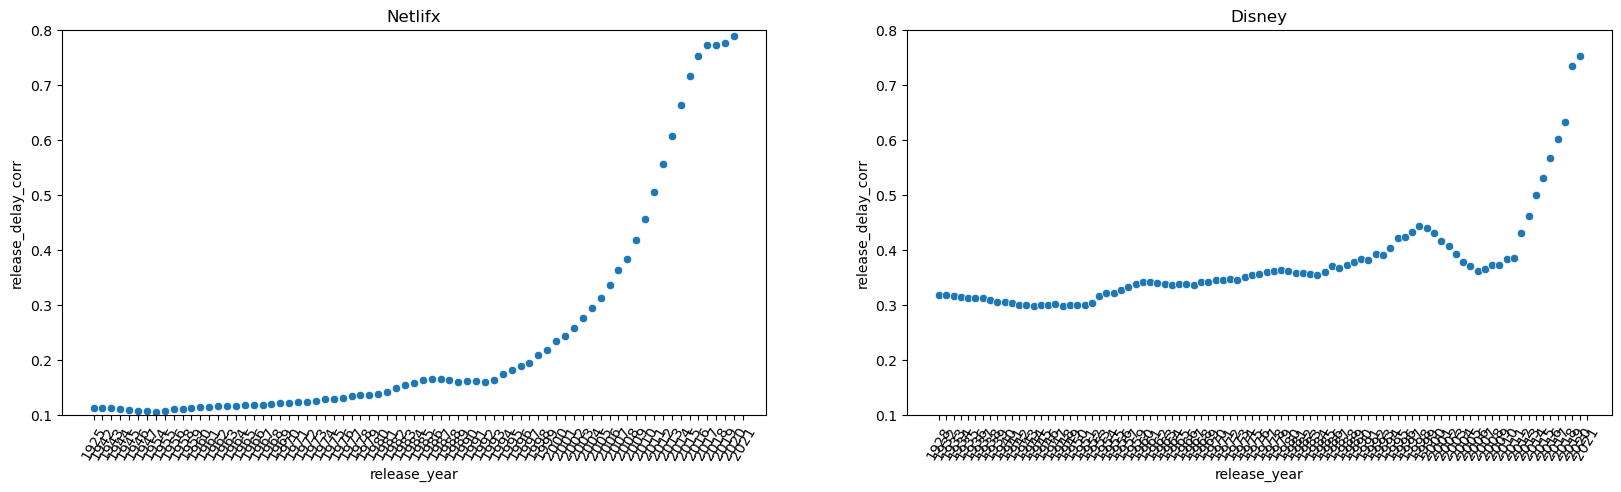

In [12]:
fig = plt.figure(figsize=(20,5))   

ax1 = fig.add_subplot(1,2,1)    
ax2 = fig.add_subplot(1,2,2)

ax1.tick_params(axis='x', labelrotation=60) 
ax2.tick_params(axis='x', labelrotation=60)

netflix_plot = release_added_corr_cumulative(netflix)[1]   
sns.scatterplot(data = netflix_plot, x=netflix_plot['release_year'], y=netflix_plot['release_delay_corr'], ax= ax1) 

disney_plot = release_added_corr_cumulative(disney)[1]  
sns.scatterplot(data = disney_plot, x=disney_plot['release_year'], y=disney_plot['release_delay_corr'], ax = ax2)

ax1.set_ylim(0.1, 0.8)
ax1.set_title("Netlifx")
ax2.set_ylim(0.1, 0.8)
ax2.set_title("Disney")
plt.show()  

두 데이터프레임을 대상으로 한 결과 모두 relase_year가 최신으로 가까워올수록 date_added와의 상관관계가 높아지는 것이 확인됩니다. 일반적인 기준으로 상관계수가 0.5를 넘을 경우 상관관계가 있고, 0.8을 넘을 경우 강력한 상관관계가 있다고 판단합니다. 두 데이터 모두 2018년을 기점으로 상관계수가 매우 강력한 범주에 들어설뿐더러 그래프의 추세가 변화하는 모습을 보이므로, 해당 년도를 기점으로 release_year가 더 오래된 데이터셋은 제거할 수 있습니다.

amazon 데이터셋은 date_added의 결측값이 지나치게 많아 해당 분석에서 제외하였으나, 분석 대상인 netflix 및 disney와 유사한 기업부문에 속하는 점, 두 분석 대상에 대한 분석 결과가 일관적인 점을 고려하여 같은 기준으로 데이터셋을 제거할 수 있다고 판단하였습니다. 이에 데이터프레임을 재정의하고, 추가적인 전처리를 진행합니다.

In [13]:
netflix_recent = slice_release_year(netflix, "2017")
amazon_recent = slice_release_year(amazon, "2017")
disney_recent = slice_release_year(disney, "2017")

### 데이터 전처리: 2차
기초 데이터셋을 release_year 기준으로 간추렸으므로, 남아있는 데이터셋에 대한 전처리를 마저 진행합니다.

#### 문자열 자료형 전처리
문자열 자료형으로 표현된 컬럼들은 통계처리에 유용하지 않으므로, 이를 인코딩하는 작업을 시행합니다. 특히 해당 데이터셋에서 문자열 자료형은 복수의 데이터가 ", "를 구분자로 하여 결합된 형태를 취하므로, 이를 분리하여 확장된 데이터셋을 만들고 이를 인코딩합니다.

In [14]:
# 'type' 컬럼을 TV Show는 1, Movie는 0으로 인코딩
netflix['type'] = pd.get_dummies(netflix['type'], drop_first=True, dtype = 'int')
netflix.rename(columns = {'type' : 'TV Show'}, inplace = True)

disney['type'] = pd.get_dummies(disney['type'], drop_first=True, dtype = 'int')
disney.rename(columns = {'type' : 'TV Show'}, inplace = True)

amazon['type'] = pd.get_dummies(amazon['type'], drop_first=True, dtype = 'int')
amazon.rename(columns = {'type' : 'TV Show'}, inplace = True)

In [15]:

# ","으로 나누어진 문자열 변수를 나누고, 필요에 따라 재분류하고, 인코딩하는 함수
def split_and_encode(dataframe, column, drop_list, replace_dict = {}):
    mlb = MultiLabelBinarizer()
    return_dataframe = dataframe[column].str.split(",", expand = True)

    for i in range(return_dataframe.shape[1]):
        return_dataframe[i] = return_dataframe[i].apply(lambda x: str(x).lstrip()) # it also converts "None" to str

    if replace_dict:
        return_dataframe.replace(replace_dict, inplace = True)

    return_dataframe = pd.DataFrame(mlb.fit_transform(return_dataframe.values.tolist()), columns=mlb.classes_)

    for drop_column in drop_list:
        return_dataframe.drop([drop_column], axis=1, inplace = True)

    dataframe[column] = return_dataframe.sum(axis=1)

    return return_dataframe

# 재분류 대상과 결과를 작성한 replace_map을 읽고 딕셔너리로 변환하여 반환하는 함수
def read_replace_map(filename):
    replace_dict = {}

    with open(filename, 'r') as file:
        lines = file.readlines()

    for line in lines:
        key,value = line.strip().split(" = ")
        replace_dict[key.strip("'")] = value.strip("'")

    return replace_dict

In [16]:
# country 컬럼을 원-핫 인코딩
netflix_recent_country = split_and_encode(netflix_recent, "country", ["None", "", "nan"])
amazon_recent_country = split_and_encode(amazon_recent, "country", ["None", "nan"])
disney_recent_country = split_and_encode(disney_recent, "country", ["None", "nan"])

netflix_recent = pd.concat([netflix_recent, netflix_recent_country], axis=1)
amazon_recent = pd.concat([amazon_recent, amazon_recent_country], axis=1)
disney_recent = pd.concat([disney_recent, disney_recent_country], axis=1)

In [17]:
# listed_in(장르정보) 컬럼을 replace_map으로 변환 후 원-핫 인코딩
replace_map = read_replace_map('listed_in_replace_map.txt')

netflix_recent_genre = split_and_encode(netflix_recent, "listed_in", ["None"], replace_map)
amazon_recent_genre = split_and_encode(amazon_recent, "listed_in", ["None"], replace_map)
disney_recent_genre = split_and_encode(disney_recent, "listed_in", ["None"], replace_map)

netflix_recent = pd.concat([netflix_recent, netflix_recent_genre], axis=1)
amazon_recent = pd.concat([amazon_recent, disney_recent_genre], axis=1)
disney_recent = pd.concat([disney_recent, amazon_recent_genre], axis=1)

In [18]:
# recent 데이터프레임에 대한 전처리가 완료되었으므로, csv로 출력
netflix_recent.to_csv(os.path.join(root_path, "netflixEDA_recent.csv"))
amazon_recent.to_csv(os.path.join(root_path, "amazonEDA_recent.csv"))
disney_recent.to_csv(os.path.join(root_path, "disneyEDA_recent.csv"))

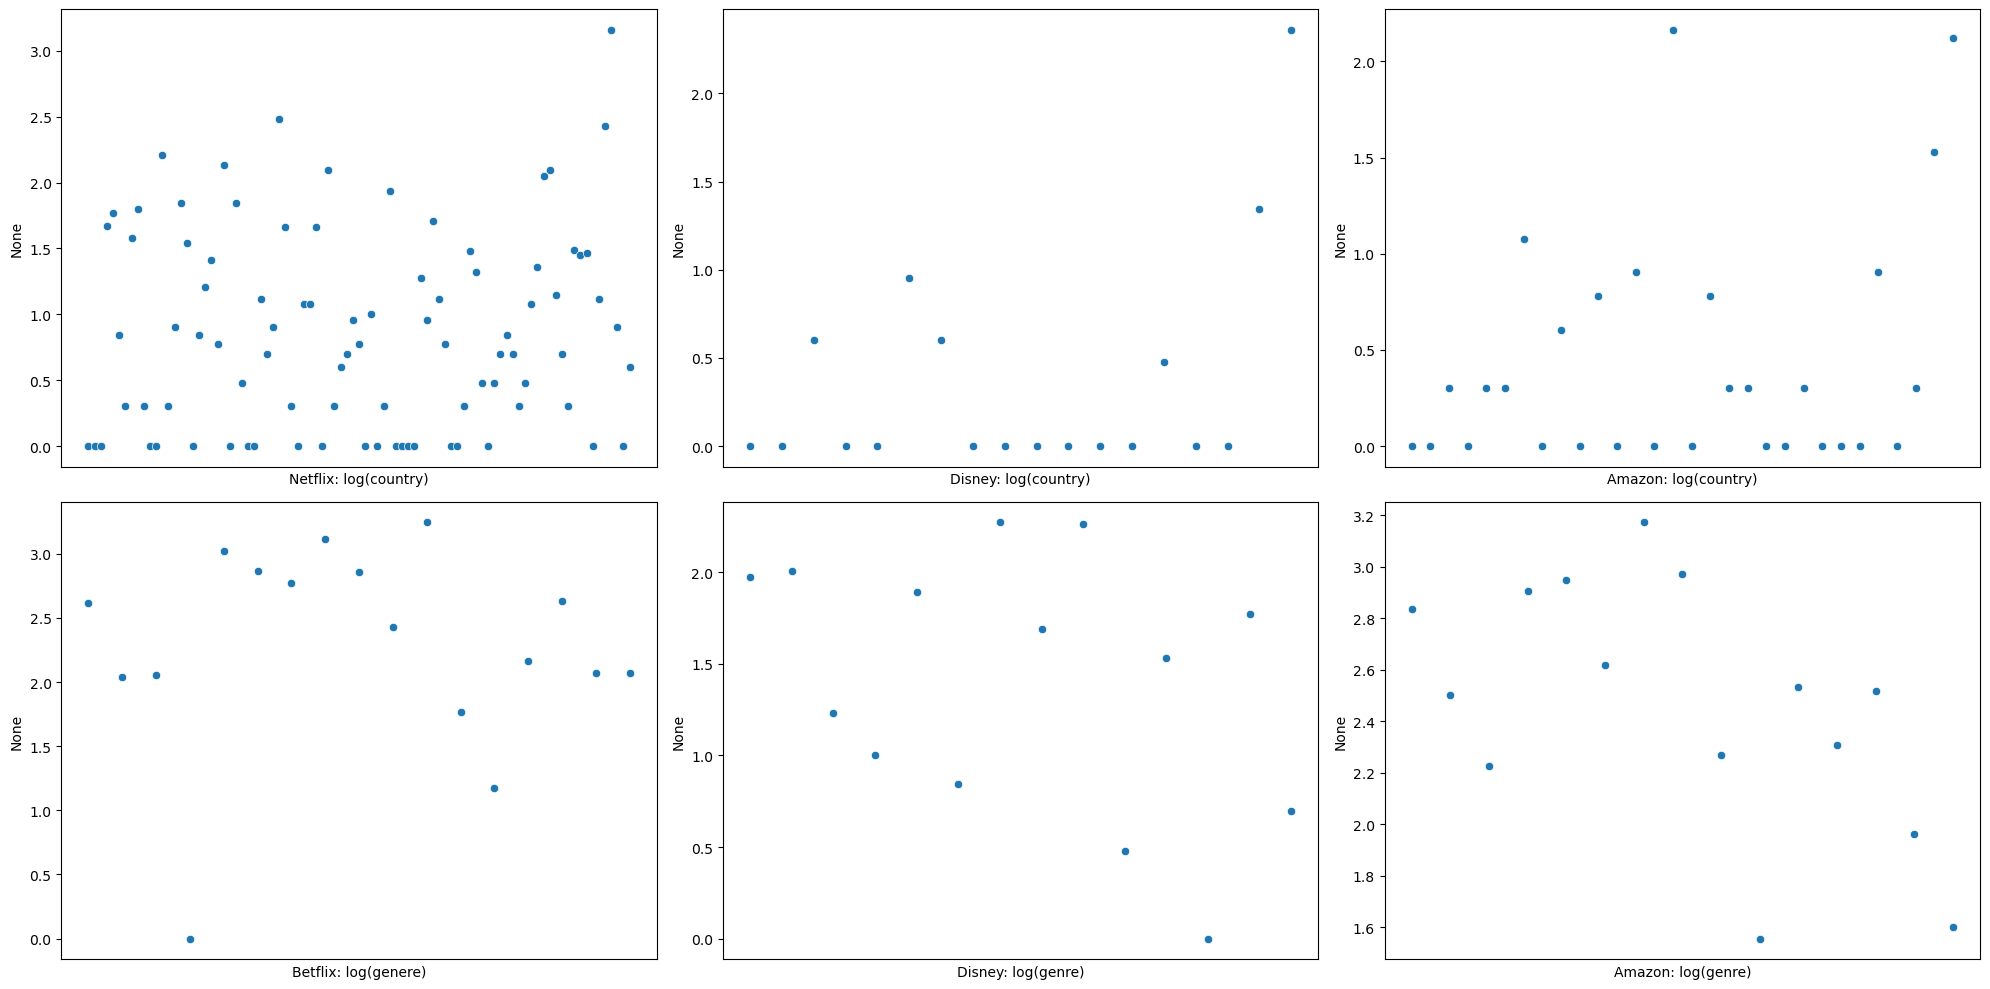

In [19]:
# 전처리된 country, listed_in 컬럼을 시각화하여 확인
fig_country = plt.figure(figsize=(20,10))

ax_netlfix_country = fig_country.add_subplot(2, 3, 1)
ax_netlfix_genre = fig_country.add_subplot(2, 3, 4)
ax_disney_country = fig_country.add_subplot(2, 3, 2)
ax_disney_genre = fig_country.add_subplot(2, 3, 5)
ax_amazon_country = fig_country.add_subplot(2, 3, 3)
ax_amazon_genre = fig_country.add_subplot(2, 3, 6)

n_c = sns.scatterplot(x = netflix_recent_country.columns, y = np.log10(netflix_recent_country.sum()), ax = ax_netlfix_country)
n_c.set_xlabel("Netflix: log(country)")
n_c.set_xticks([], [])
# n_c.set_xticklabels(labels = netflix_recent_country.columns, rotation = 60)

n_g = sns.scatterplot(x = netflix_recent_genre.columns, y = np.log10(netflix_recent_genre.sum()), ax = ax_netlfix_genre)
n_g.set_xlabel("Betflix: log(genere)")
n_g.set_xticks([], [])
# n_g.set_xticklabels(labels = netflix_recent_genre.columns, rotation = 60)

d_c = sns.scatterplot(x = disney_recent_country.columns, y = np.log10(disney_recent_country.sum()), ax = ax_disney_country)
d_c.set_xlabel("Disney: log(country)")
d_c.set_xticks([], [])
# d_c.set_xticklabels(labels = disney_recent_country.columns, rotation = 60)

d_g = sns.scatterplot(x = disney_recent_genre.columns, y = np.log10(disney_recent_genre.sum()), ax = ax_disney_genre)
d_g.set_xlabel("Disney: log(genre)")
d_g.set_xticks([], [])
# d_g.set_xticklabels(labels = disney_recent_genre.columns, rotation = 60)

a_c = sns.scatterplot(x = amazon_recent_country.columns, y = np.log10(amazon_recent_country.sum()), ax = ax_amazon_country)
a_c.set_xlabel("Amazon: log(country)")
a_c.set_xticks([], [])
# a_c.set_xticklabels(labels = amazon_recent_country.columns, rotation = 60)

a_g = sns.scatterplot(x = amazon_recent_genre.columns, y = np.log10(amazon_recent_genre.sum()), ax = ax_amazon_genre)
a_g.set_xlabel("Amazon: log(genre)")
a_g.set_xticks([], [])
# a_g.set_xticklabels(labels = amazon_recent_genre.columns, rotation = 60)

plt.tight_layout()
plt.show()

## 인사이트 도출을 위한 데이터 전환
### Q-Q Plot을 통해 플랫폼별 country 분포를 시각화
모든 플랫폼에서 country 항목의 분포는 로그값을 취해도 지수적으로 분포하는 모습을 보입니다. 즉, 국가별 컨텐츠의 배급량은 기하급수의 기하급수 형태로 분포하여, 그 편중이 매우 극단적으로 높다는 것을 의미합니다. 단, 배급량이 적은 일부 국가들의 경우 Q-Q 플롯상에서 확인할 수 있듯이 이러한 분포에서 예외적인 모습을 보이는데, 이는 해당 국가들의 경우 정상적인 사업이 이루어지는 국가가 아니라 초기 진출을 타진하는 국가들이라는 점에서 예상할 수 있는 부분입니다. 이러한 국가들은 통계적으로 더 나은 인사이트를 얻기 위해 데이터에서 제거할 수 있습니다.

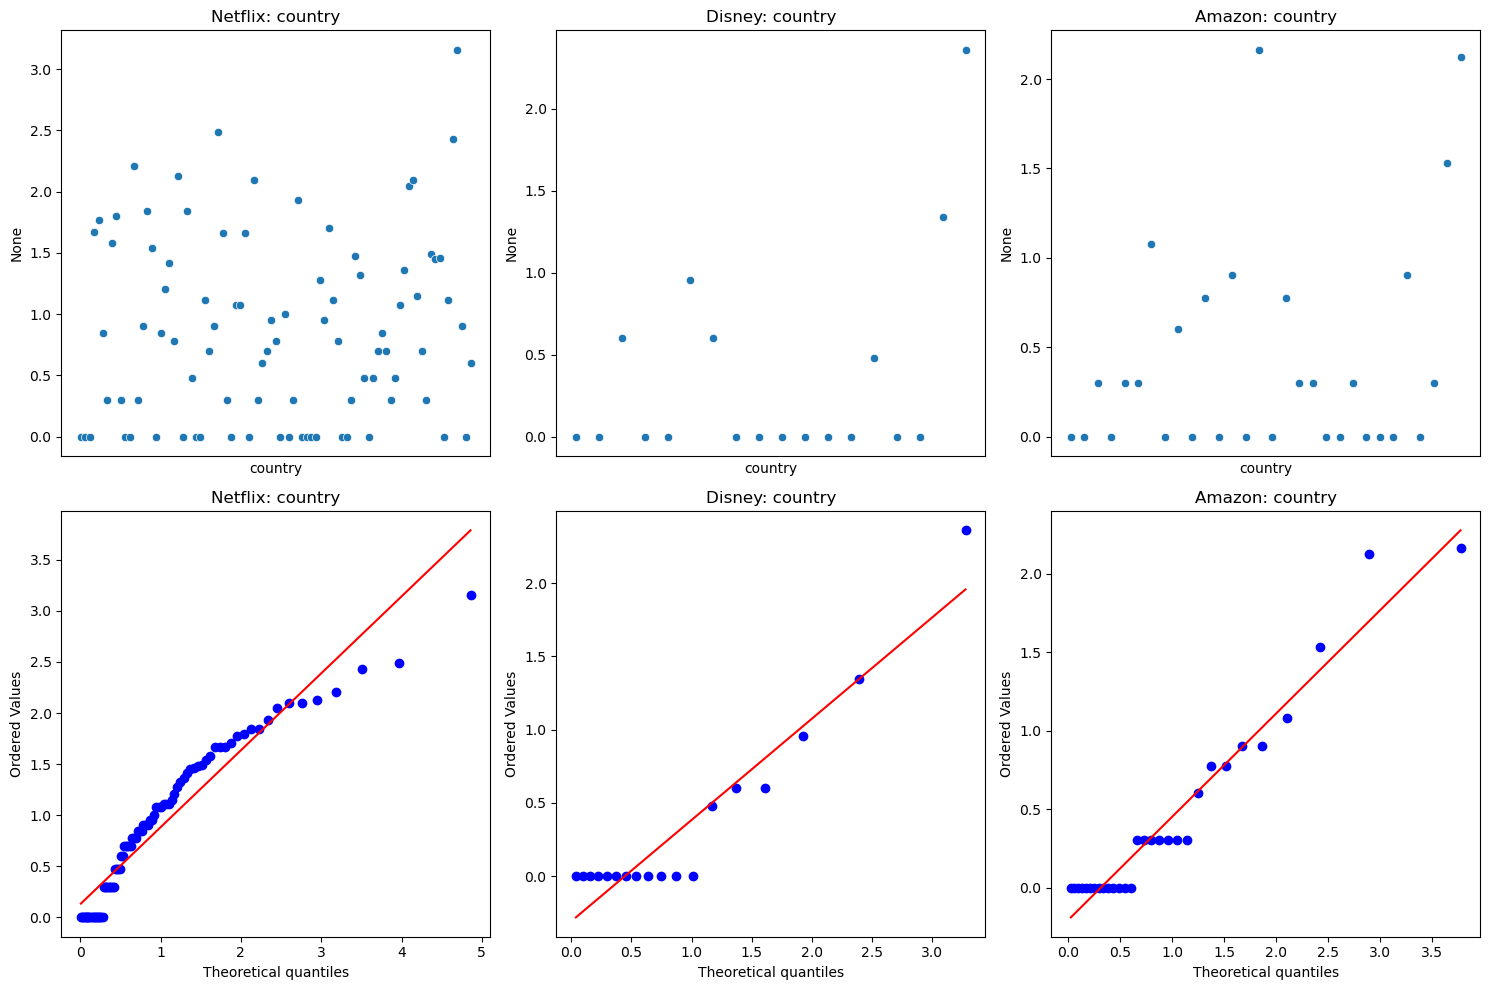

In [20]:
fig = plt.figure(figsize = (15, 10))

ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

n_c = sns.scatterplot(x = netflix_recent_country.columns, y = np.log10(netflix_recent_country.sum()), ax = ax1)
n_c.set_xlabel("country")
n_c.set_xticks([], [])

d_c = sns.scatterplot(x = disney_recent_country.columns, y = np.log10(disney_recent_country.sum()), ax = ax2)
d_c.set_xlabel("country")
d_c.set_xticks([], [])

a_c = sns.scatterplot(x = amazon_recent_country.columns, y = np.log10(amazon_recent_country.sum()), ax = ax3)
a_c.set_xlabel("country")
a_c.set_xticks([], [])

stats.probplot(np.log10(netflix_recent_country.sum()), dist="expon", plot = ax4)
stats.probplot(np.log10(disney_recent_country.sum()), dist="expon", plot = ax5)
stats.probplot(np.log10(amazon_recent_country.sum()), dist="expon", plot = ax6)

ax1.set_title('Netflix: country')
ax4.set_title('Netflix: country')
ax2.set_title('Disney: country')
ax5.set_title('Disney: country')
ax3.set_title('Amazon: country')
ax6.set_title('Amazon: country')

fig.tight_layout()
plt.show()

In [21]:
# 배급된 컨텐츠의 양을 기준으로 relevant한 국가들을 추출
netflix_recent_country_relevant = netflix_recent_country[netflix_recent_country.sum()[netflix_recent_country.sum() > 25].index]
netflix_recent_country_relevant.name = "netflix_country"
disney_recent_country_relevant = disney_recent_country[disney_recent_country.sum()[disney_recent_country.sum() > 0].index]
disney_recent_country_relevant.name = "disney_country"
amazon_recent_country_relevant = amazon_recent_country[amazon_recent_country.sum()[amazon_recent_country.sum() > 1].index]
amazon_recent_country_relevant.name = "amazone_cuntry"

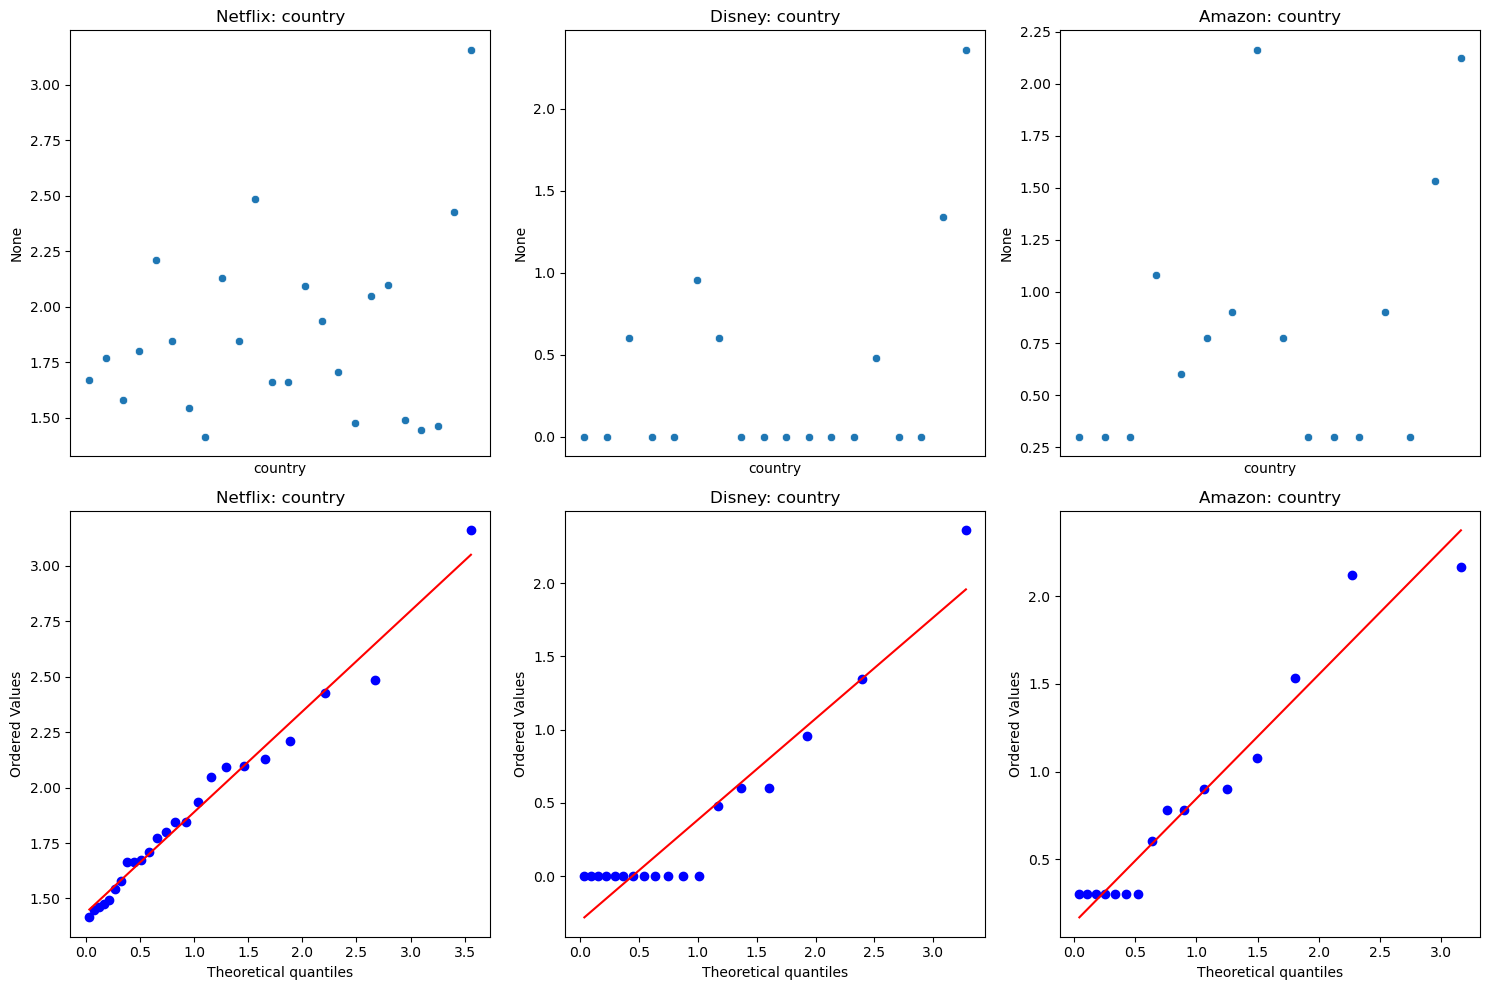

In [22]:
#relevant한 값에 대한 재시각화
fig = plt.figure(figsize = (15, 10))

ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

n_c = sns.scatterplot(x = netflix_recent_country_relevant.columns, y = np.log10(netflix_recent_country_relevant.sum()), ax = ax1)
n_c.set_xlabel("country")
n_c.set_xticks([], [])

d_c = sns.scatterplot(x = disney_recent_country_relevant.columns, y = np.log10(disney_recent_country_relevant.sum()), ax = ax2)
d_c.set_xlabel("country")
d_c.set_xticks([], [])

a_c = sns.scatterplot(x = amazon_recent_country_relevant.columns, y = np.log10(amazon_recent_country_relevant.sum()), ax = ax3)
a_c.set_xlabel("country")
a_c.set_xticks([], [])

stats.probplot(np.log10(netflix_recent_country_relevant.sum()), dist="expon", plot = ax4)
stats.probplot(np.log10(disney_recent_country_relevant.sum()), dist="expon", plot = ax5)
stats.probplot(np.log10(amazon_recent_country_relevant.sum()), dist="expon", plot = ax6)

ax1.set_title('Netflix: country')
ax4.set_title('Netflix: country')
ax2.set_title('Disney: country')
ax5.set_title('Disney: country')
ax3.set_title('Amazon: country')
ax6.set_title('Amazon: country')

fig.tight_layout()
plt.show()

### Q-Q Plot을 통해 플랫폼별 listed_in 분포를 시각화
모든 플랫폼에서 listed_in 항목의 분포는 지수적으로 분포하는 모습을 보입니다. 이를 통해 listed_in 항목을 20여개로 병합한 것이 통계적으로 유의미한 결정이었다는 것을 확인할 수 있습니다.

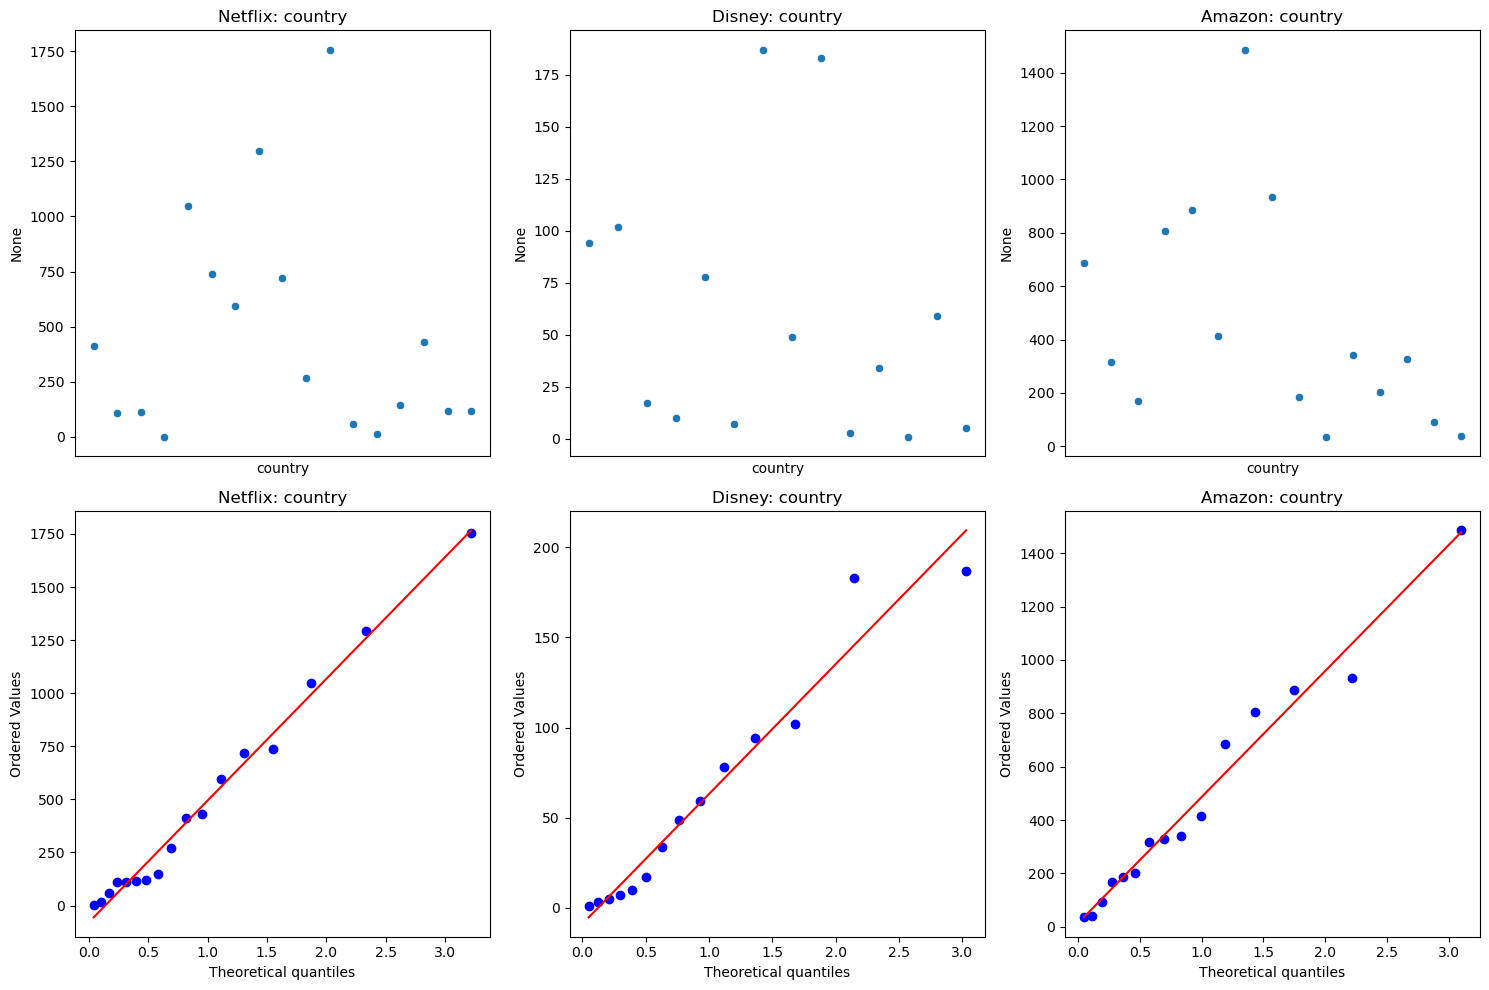

In [23]:
#relevant한 값에 대한 재시각화
fig = plt.figure(figsize = (15, 10))

ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

n_c = sns.scatterplot(x = netflix_recent_genre.columns, y = netflix_recent_genre.sum(), ax = ax1)
n_c.set_xlabel("country")
n_c.set_xticks([], [])

d_c = sns.scatterplot(x = disney_recent_genre.columns, y = disney_recent_genre.sum(), ax = ax2)
d_c.set_xlabel("country")
d_c.set_xticks([], [])

a_c = sns.scatterplot(x = amazon_recent_genre.columns, y = amazon_recent_genre.sum(), ax = ax3)
a_c.set_xlabel("country")
a_c.set_xticks([], [])

stats.probplot(netflix_recent_genre.sum(), dist="expon", plot = ax4)
stats.probplot(disney_recent_genre.sum(), dist="expon", plot = ax5)
stats.probplot(amazon_recent_genre.sum(), dist="expon", plot = ax6)

ax1.set_title('Netflix: country')
ax4.set_title('Netflix: country')
ax2.set_title('Disney: country')
ax5.set_title('Disney: country')
ax3.set_title('Amazon: country')
ax6.set_title('Amazon: country')

fig.tight_layout()
plt.show()

### 시각화된 자료에 대한 해석
이상치 제거 후 Q-Q플롯으로 다시 시각화를 한 결과, country와 listed_in 모두 전체적인 분포가 전형적으로 변한 것을 알 수 있습니다. 다만, Disney와 Amazon의 경우 country 컬럼에 여전히 이상치가 남아있는 것을 볼 수 있습니다. 이는 두 플랫폼의 사업이 아직 충분히 성숙하지 못하여 정상적인 영업주기에 이르지 못한 국가들이 많음을 의미합니다. 이러한 국가들을 제외할 경우, 이후 진행할 배급대상 국가별 군집화 분석의 대상 국가가 지나치게 적어 유효한 인사이트를 제공하기 힘듭니다. 따라서 해당하는 표본은 제거하지 않고 분석에 포함하도록 하겠습니다.

## 데이터 분석
길고 긴 데이터 전처리가 끝났습니다. 이제 정제된 데이터를 이용하여 분석을 진행합니다. 분석의 목표가 되는 가설은 다음과 같습니다.

1. 각 컨텐츠가 출시되는 국가들은 통계적으로 군집화가 가능할 것이며, 그 군집은 플랫폼별로 차이가 있을 것이다.
2. 각 컨텐츠의 장르는 출시되는 국가에 따라 다르게 분포할 것이다.

### 가설 1에 대한 작업: 컨텐츠 배급대상 국가별 군집화 작업
어떤 플랫폼에서 특정 컨텐츠를 배급할 때, 전세계에 동일한 기준으로 배급하지는 않을 것입니다. 서로 다른 문화와 역사, 언어를 가진 국가들은 각각의 컨텐츠에 대해 서로 다르게 반응할 것입니다. 그렇다고 해서 모든 국가에 제각각의 기준을 갖고 컨텐츠를 배급하지도 않을 것입니다. 각 국가들은 문화적 유사성, 지리적 인접성 등으로 크게 군집화할 수 있으며, 따라서 배급되는 컨텐츠의 유사성 역시 군집화될 것이라고 예상할 수 있을 것입니다. 그 예상이 사실인지를 우리가 가진 데이터로 검증해보도록 하겠습니다.

#### 탐험적 연구: 국가 자료에 대한 상관행렬 도출 및 시각화
컨텐츠의 배급대상 국가간 상관관계가 있는지를 분석합니다. 상관관계가 없다면 군집화가 불가능하고, 유의미한 인사이트를 도출할 수 없습니다. 배급대상 국가 데이터프레임으로 상관행렬을 도출하고, 통계적으로 분석을 진행하기 전에 간단히 heatmap 형식으로 시각화해보도록 하겠습니다.

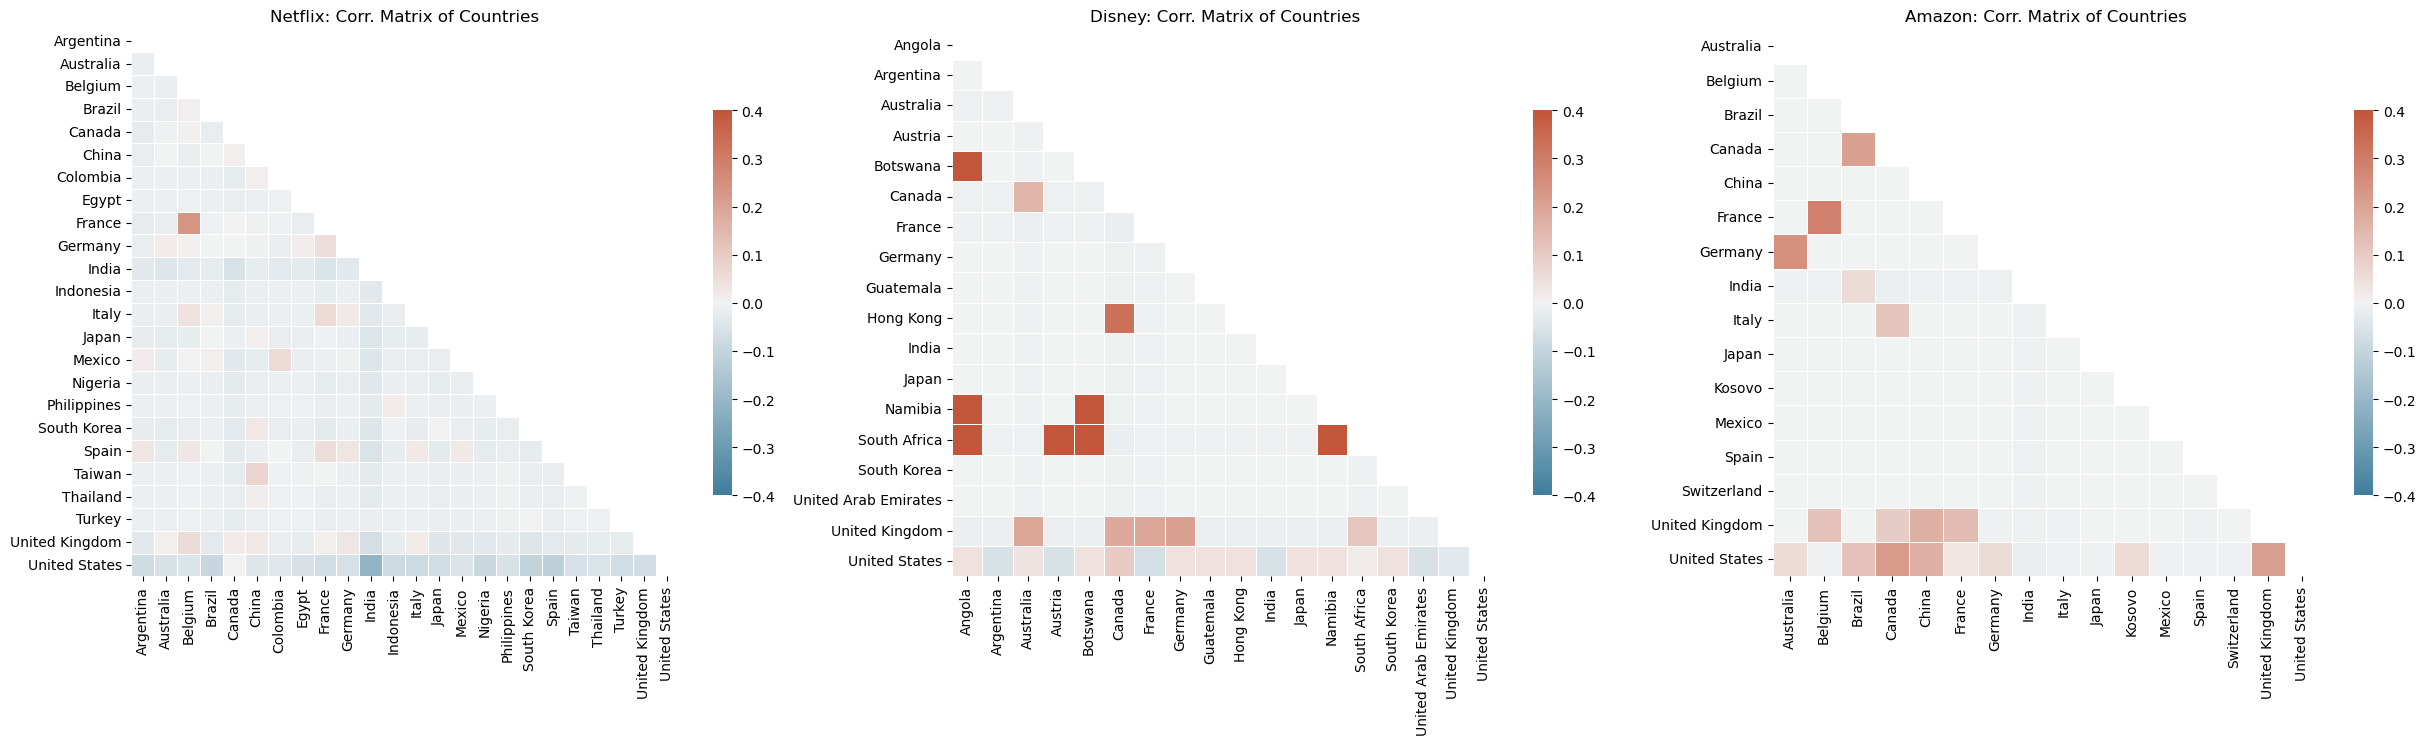

In [24]:
netflix_corr = netflix_recent_country_relevant.corr()
netflix_mask = np.triu(np.ones_like(netflix_corr, dtype=bool))
netflix_corr.name = "Netflix Countries"

amazon_corr = amazon_recent_country_relevant.corr()
amazon_mask = np.triu(np.ones_like(amazon_corr, dtype=bool))
amazon_corr.name = "Amazon Countries"

disney_corr = disney_recent_country_relevant.corr()
disney_mask = np.triu(np.ones_like(disney_corr, dtype=bool))
disney_corr.name = "Disney Countries"

cmap = sns.diverging_palette(230, 20, as_cmap=True)

vmin = -0.4
vmax = 0.4

fig = plt.figure(figsize = (30, 10))
ax_netflix = fig.add_subplot(1, 3, 1)
ax_amazon = fig.add_subplot(1, 3, 3)
ax_disney = fig.add_subplot(1, 3, 2)

sns.heatmap(netflix_corr, mask=netflix_mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": .5}, vmin = vmin, vmax = vmax, ax = ax_netflix)
sns.heatmap(amazon_corr, mask=amazon_mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": .5}, vmin = vmin, vmax = vmax, ax = ax_amazon)
sns.heatmap(disney_corr, mask=disney_mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": .5}, vmin = vmin, vmax = vmax, ax = ax_disney)

ax_netflix.set_title("Netflix: Corr. Matrix of Countries")
ax_amazon.set_title("Amazon: Corr. Matrix of Countries")
ax_disney.set_title("Disney: Corr. Matrix of Countries")

plt.show()

예상한 바와 같이, 각 국가별 상관계수가 서로 다른 모습을 확인할 수 있습니다. 또한, 상관계수의 분포가 플랫폼별로도 뚜렷이 다른 점을 알 수 있습니다. 

Netflix의 경우, 국가간 음의 상관관계를 갖는 경우가 많이 관찰됩니다. 이는 컨텐츠 사업이 매우 성숙하여 각 국가별 맞춤형 컨텐츠를 충분히 제공하고 있음을 나타냅니다. 특히, 컨텐츠 배급량으로는 압도적인 1위를 점하는 United States가 다른 거의 모든 국가들과 거리가 매우 먼 것을 확인할 수 있는데, 이는 미국에 압도적으로 많은 양의 컨텐츠를 공급하고도 각 국가별 맞춤형 컨텐츠를 제공할 여력이 있을 정도로 컨텐츠 포트폴리오의 규모가 방대함을 의미한다고 볼 수 있습니다. 이는 반대로 말하자면 Netflix에서는 특정 국가를 타게팅해서 맞춤형으로 컨텐츠를 만드는 것이 특정 문화권 또는 글로벌을 타게팅해서 만드는 것보다 훨씬 적합한 전략이라는 것을 시사합니다.

Disney의 경우, 매우 강한 양의 상관관계를 갖는 국가들이 관찰됩니다. 이는 이후 진행할 군집분석에서 뚜렷한 군집이 확인될 것이라는 것을 시사하며, Disney가 아직은 Netflix처럼 국가별 맞춤형에 이를 정도의 컨텐츠 제공량을 달성하지 못했다는 것을 시사합니다. 다만, United States는 Disney에서도 다른 국가들과 음의 상관관계를 갖는 경우가 많은 것으로 보아, 미국 시장에 맞춤형 컨텐츠를 제공하는 것에 집중했다고 짐작할 수 있습니다.

Amazon의 경우, 국가간 음의 상관관계를 갖는 경우를 거의 찾을 수 없습니다. 따라서 이후 진행할 군집분석에서 뚜렷한 군집을 찾아낼 수 없을 것으로 보입니다.

#### 계층적 군집분석 및 MDS 시각화

/tmp/ipykernel_36365/1097994469.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method=link_method)
/tmp/ipykernel_36365/1097994469.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method=link_method)
/tmp/ipykernel_36365/1097994469.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method=link_method)


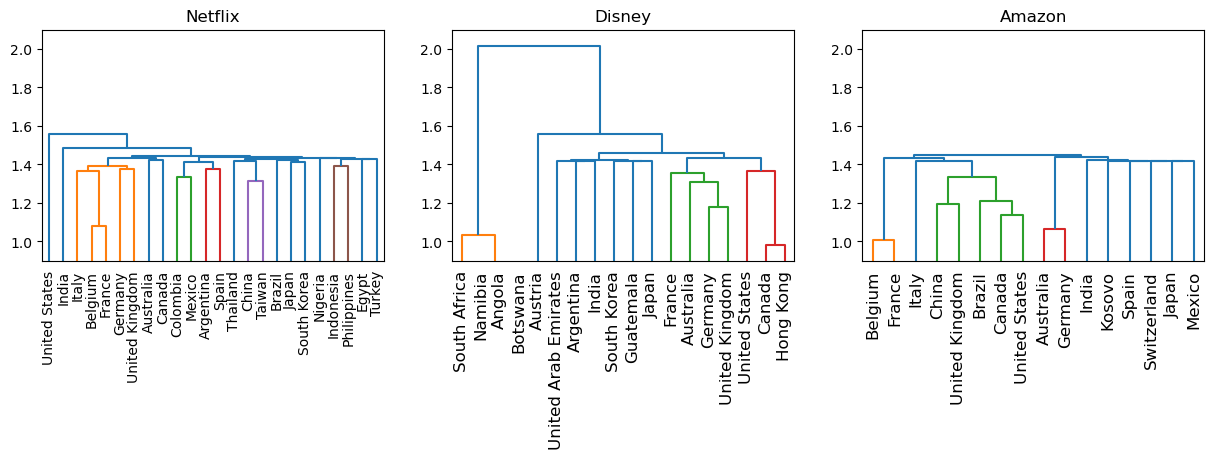

In [25]:
def h_clustering(correlation_matrix, link_method = "average"):
    distance_matrix = 1 - correlation_matrix
    linkage_matrix = sch.linkage(distance_matrix, method=link_method)
    
    return distance_matrix, linkage_matrix

figure = plt.figure(figsize=(15, 3))
ax1 = figure.add_subplot(1, 3, 1)
ax2 = figure.add_subplot(1, 3, 2)
ax3 = figure.add_subplot(1, 3, 3)

sch.dendrogram(h_clustering(netflix_corr)[1], labels = h_clustering(netflix_corr)[0].columns, ax = ax1, leaf_rotation=90, color_threshold=1.4)
sch.dendrogram(h_clustering(disney_corr)[1], labels = h_clustering(disney_corr)[0].columns, ax = ax2, leaf_rotation=90, color_threshold=1.4)
sch.dendrogram(h_clustering(amazon_corr)[1], labels = h_clustering(amazon_corr)[0].columns, ax = ax3, leaf_rotation=90, color_threshold=1.4)

ax1.set_title("Netflix")
ax2.set_title("Disney")
ax3.set_title("Amazon")

ax1.set_ylim(0.9, 2.1)
ax2.set_ylim(0.9, 2.1)
ax3.set_ylim(0.9, 2.1)

plt.show()

/tmp/ipykernel_36365/309283481.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method=link_method)


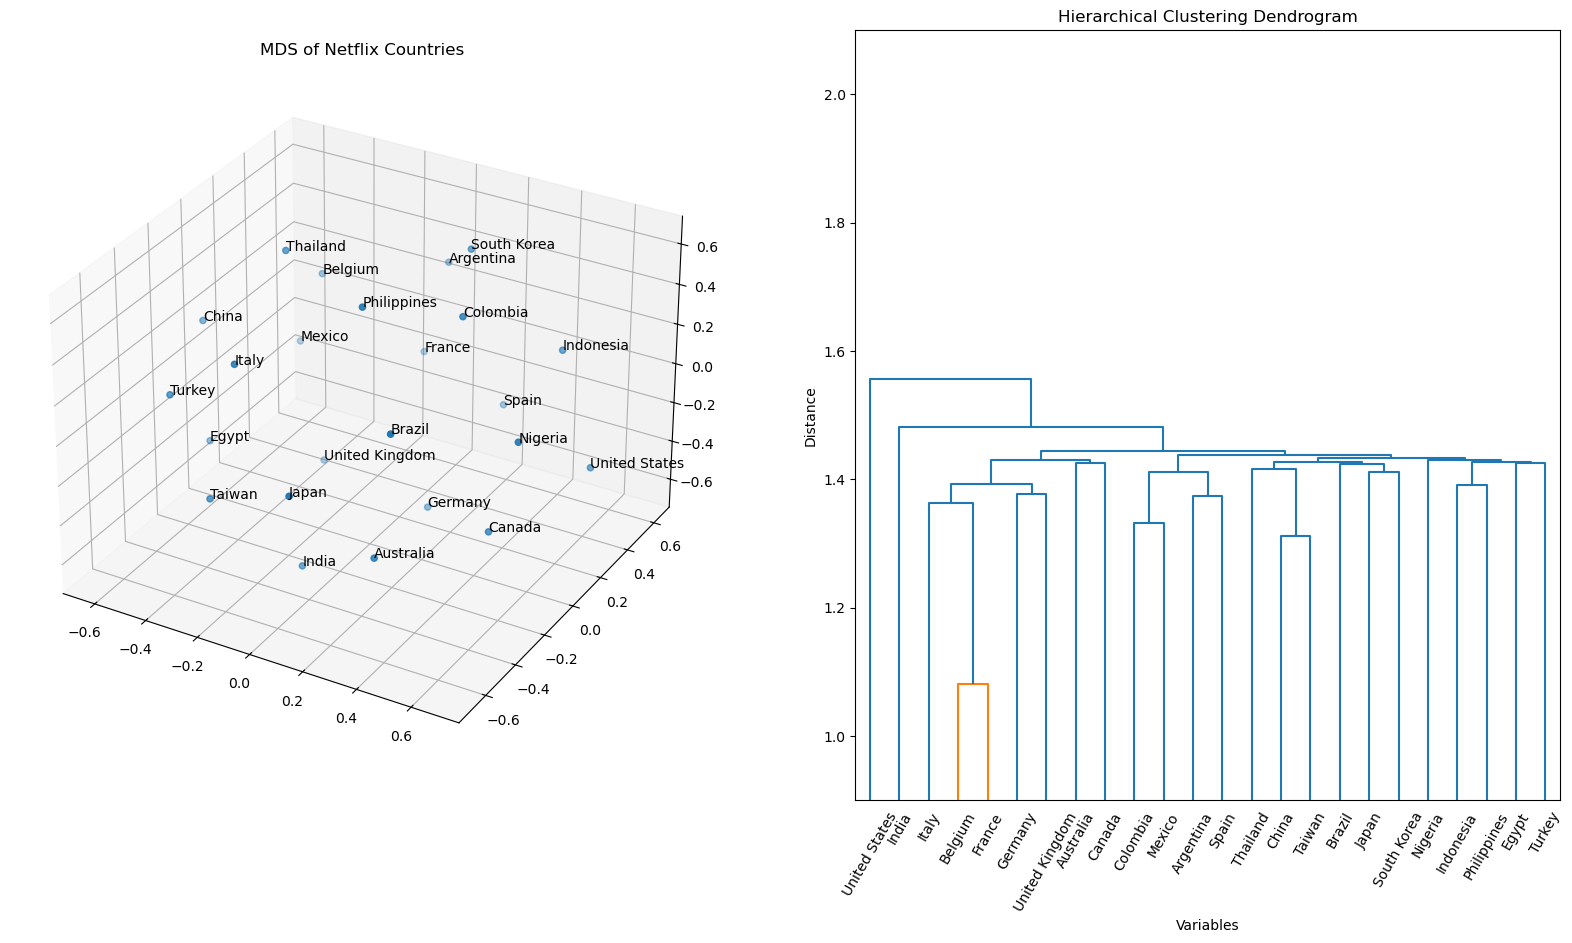

/tmp/ipykernel_36365/309283481.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method=link_method)


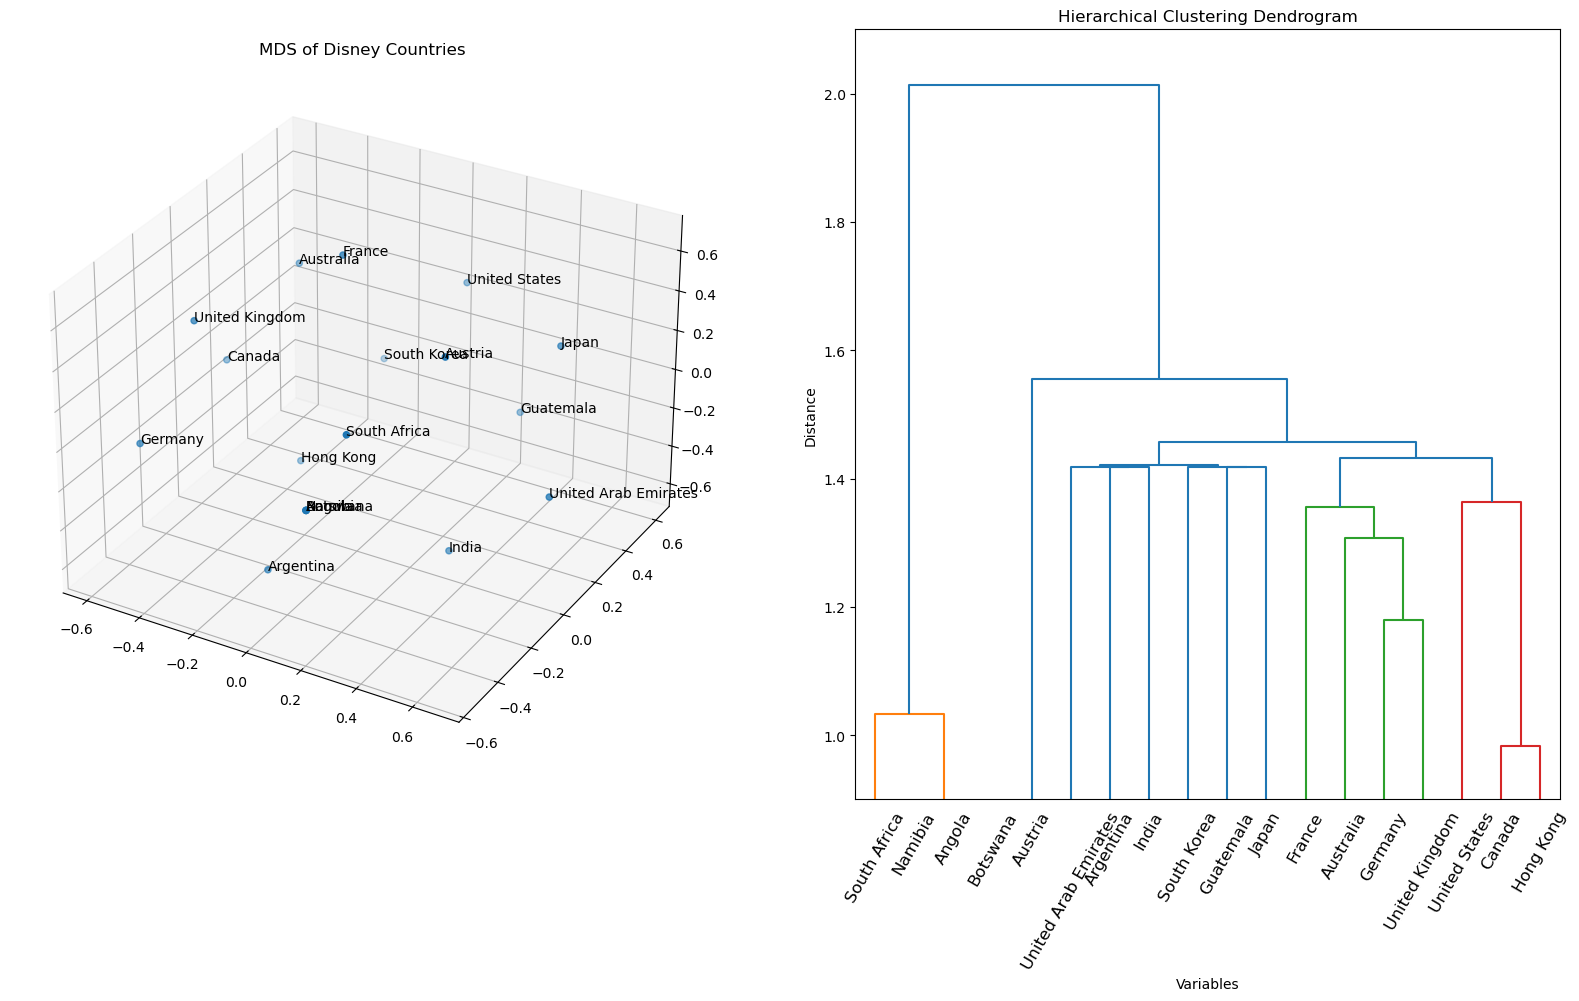

/tmp/ipykernel_36365/309283481.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method=link_method)


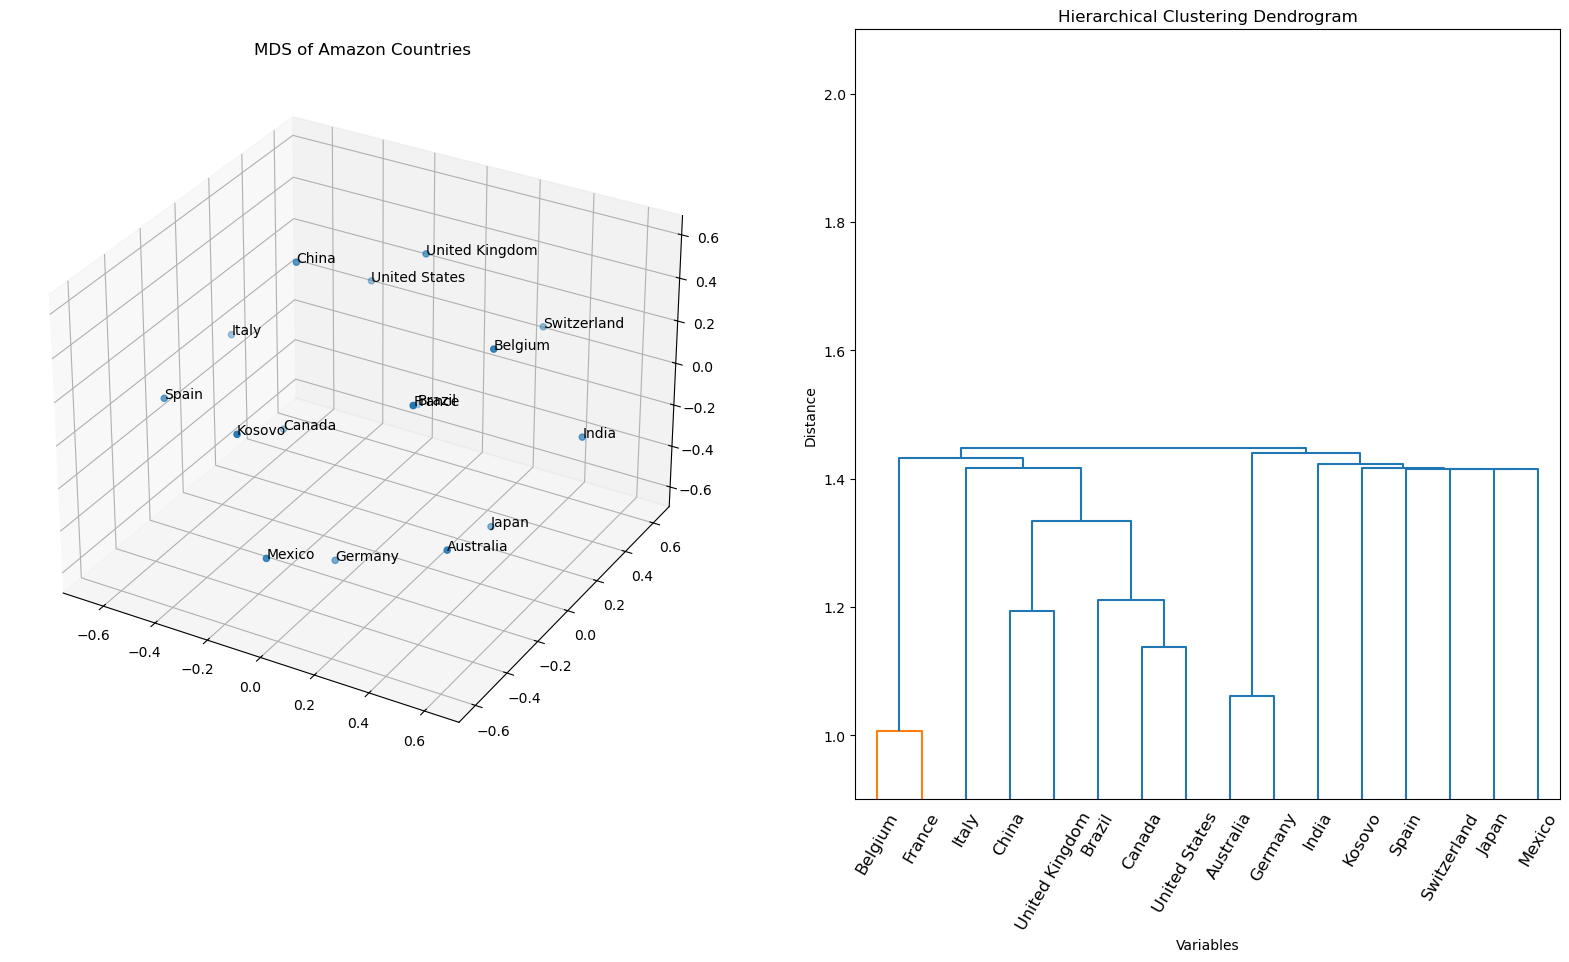

In [26]:
def h_clustering(correlation_matrix, link_method = "average"):
    distance_matrix = 1 - correlation_matrix
    linkage_matrix = sch.linkage(distance_matrix, method=link_method)
    
    mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(distance_matrix)
    
    mds_df = pd.DataFrame(mds_coords, columns=['MDS1', 'MDS2', 'MDS3'])
    mds_df['Variable'] = correlation_matrix.columns
    
    figure = plt.figure(figsize=(20, 10))
    ax1 = figure.add_subplot(1, 2, 1, projection="3d")
    ax2 = figure.add_subplot(1, 2, 2)
    
    ax1.scatter(mds_coords[:, 0], mds_coords[:, 1], mds_coords[:, 2])
    ax2 = sch.dendrogram(linkage_matrix, labels=distance_matrix.columns)
    
    ax1.set_title(f"MDS of {correlation_matrix.name}")
    
    for i, var in enumerate(correlation_matrix.columns):
        ax1.text(mds_coords[i, 0], mds_coords[i, 1], mds_coords[i, 2], var)
    
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Variables')
    plt.xticks(rotation=60)
    plt.ylabel('Distance')
    plt.ylim(0.9, 2.1)
    plt.show()

h_clustering(netflix_corr)
h_clustering(disney_corr)
h_clustering(amazon_corr)


#### 군집분석 결과 해석
상관행렬 시각화를 통해 확인한 내용에서 크게 벗어나지 않는 것을 확인할 수 있습니다. 특징적으로는 Netflix의 경우 계층적 군집화가 사실상 불가능할 정도로 모든 국가들이 서로 거리가 멀다는 점과, 그에 비해 다른 두 플랫폼은 정도의 차이만 있을 뿐 계층적 군집화가 가능하다는 점이 있습니다. 그러나 이것이 해당 군집을 타게팅한 컨텐츠를 제작하여 납품할 수 있는 기회인지는 명확치 않은데, 다른 두 플랫폼 역시 사업이 성숙하며 국가별 맞춤형 컨텐츠를 제공하는 방향으로 나아갈 것으로 예상되기 때문입니다.

다른 한편으로, 해당 군집분석 결과를 3차원 MDS법을 이용해 시각화한 결과에서 군집을 뚜렷이 관찰할 수 없는 점 역시 특기할 만 합니다. 이는 각 국가간 거리공간이 4차원 이상의 고차원 공간에 존재하여 3차원 시각화로는 특징을 충분히 드러낼 수 없다는 점을 뜻할 것입니다.

### 가설 2에 대한 작업: 컨텐츠 배급대상 국가와 컨텐츠의 장르에 대한 독립성 검정


#### genre 데이터프레임을 정규화하는 이유

In [28]:
# dataframe_recnet_genre를 정규화

netflix_recent_genre = netflix_recent_genre.astype(float)
netflix_recent_genre = netflix_recent_genre.div(netflix_recent_genre.sum(axis = 1), axis = 0)
netflix_recent_genre.name = "Netflix_genre"

disney_recent_genre = disney_recent_genre.astype(float)
disney_recent_genre = disney_recent_genre.div(disney_recent_genre.sum(axis = 1), axis = 0)
disney_recent_genre.name = "Disney_genre"

amazon_recent_genre = amazon_recent_genre.astype(float)
amazon_recent_genre = amazon_recent_genre.div(amazon_recent_genre.sum(axis = 1), axis = 0)
amazon_recent_genre.name = "Amazon_genre"

# recent_country
netflix_recent_country_relevant = netflix_recent_country_relevant.astype(float)
netflix_recent_country_relevant = netflix_recent_country_relevant.div(netflix_recent_country_relevant.sum(axis=0), axis=1)
netflix_recent_country_relevant.name = "Amazon_country"

disney_recent_country_relevant = disney_recent_country_relevant.astype(float)
disney_recent_country_relevant = disney_recent_country_relevant.div(disney_recent_country_relevant.sum(axis=0), axis=1)
disney_recent_country_relevant.name = "Disney_country"

amazon_recent_country_relevant = amazon_recent_country_relevant.astype(float)
amazon_recent_country_relevant = amazon_recent_country_relevant.div(amazon_recent_country_relevant.sum(axis=0), axis=1)
amazon_recent_country_relevant.name = "Amazon_country"

#### 정규화된 genre 데이터프레임에 대해 카이제곱 검정 시행

In [29]:
from scipy.stats import chi2_contingency

def chi2_and_heatmap(country, genre, ax):
    contingency_table = country.T.dot(genre)
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Print the results
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-value: {p}")
    # Interpret the results
    if p < 0.05:
        print("There is a significant association between genres and countries.")
    else:
        print("There is no significant association between genres and countries.")

    sns.heatmap(contingency_table, annot=False, cmap='coolwarm', ax = ax)
    ax.set_title(f'{country.name} and {genre.name}')

Chi2 Statistic: 19.371140230931683
P-value: 1.0
There is no significant association between genres and countries.
Chi2 Statistic: 36.70221582156205
P-value: 1.0
There is no significant association between genres and countries.
Chi2 Statistic: 32.77680612101607
P-value: 1.0
There is no significant association between genres and countries.


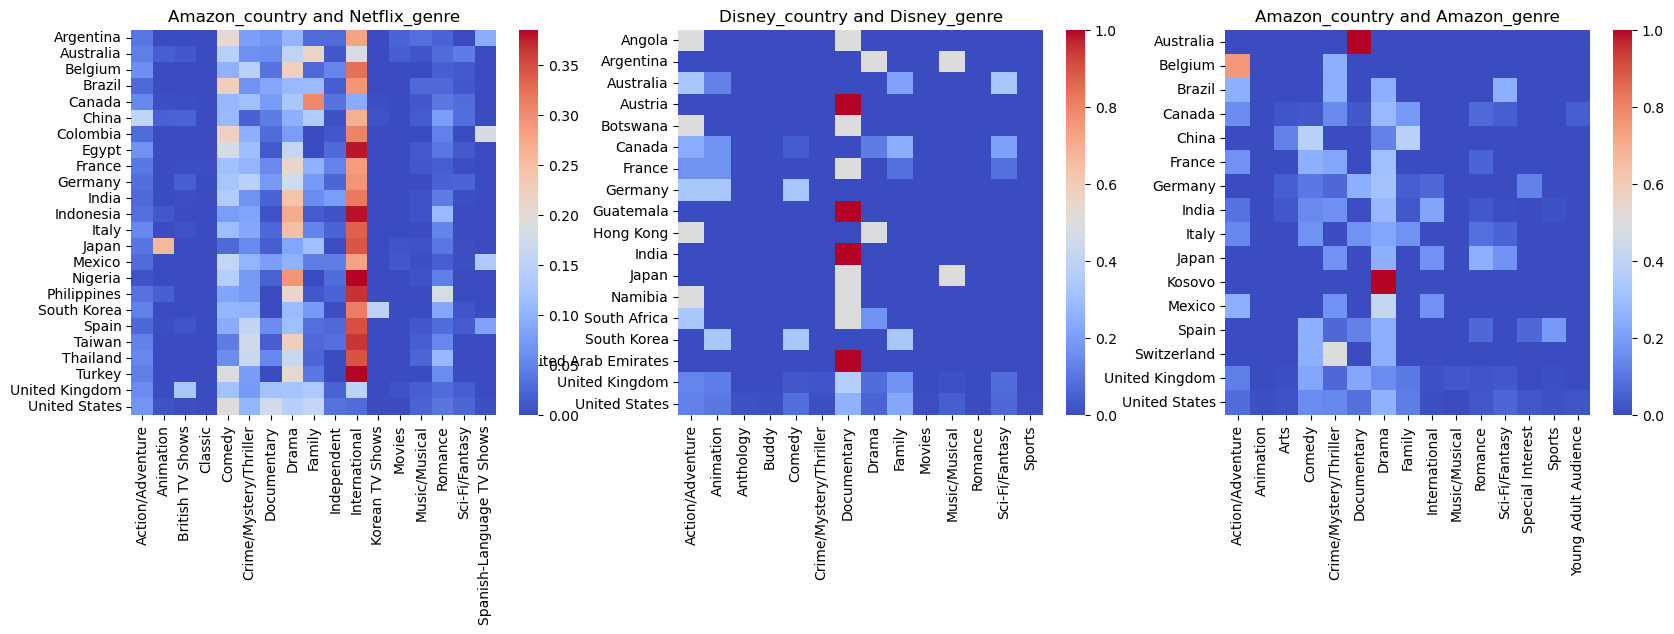

In [31]:
fig = plt.figure(figsize = (20, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

chi2_and_heatmap(netflix_recent_country_relevant, netflix_recent_genre, ax1)
chi2_and_heatmap(disney_recent_country_relevant, disney_recent_genre, ax2)
chi2_and_heatmap(amazon_recent_country_relevant, amazon_recent_genre, ax3)

#### 카이제곱검정 및 분할표에 대한 해석 

## 결론